## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<hr>

## Loading Files

In [2]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy')
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')

print(X.shape, y.shape)

(20000, 6, 28) (20000,)


In [3]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, X_val.shape)

(16000, 6, 28) (4000, 6, 28)


<hr>

## Dataset class

In [4]:
class SimpleDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])  # shape: (6, 28)
        y = torch.tensor(self.labels[idx])
        return {"x": x, "y": y}

In [5]:
# For evaluation
val_dataset = SimpleDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

<hr>

## Model

In [6]:
################ CNN Backbone
def conv_block(in_channels: int, out_channels: int) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
    )
 
 
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)

        self.global_pool = nn.AdaptiveAvgPool1d((1))
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
 
        x=self.global_pool(x)

        x = x.view(x.size(0), -1)

        return x
 
 
################ Fully connected network
class FC(nn.Module):
    def __init__(self,input_dim):
        super(FC, self).__init__()
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x=self.fco(x)
        return x

In [ ]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

# Initialize and load models
backbone = cnn()
backbone.to(device)

fc = FC(1024)
fc.to(device)

backbone.load_state_dict(backbone_state)
fc.load_state_dict(fc_state)

<All keys matched successfully>

<hr>

## Evaluation Function

In [8]:
def eval_perf(dataloader, backbone, fc, device):
    backbone.eval()
    fc.eval()

    pred=[]
    gt=[]

    with torch.no_grad():
        for batch in dataloader:
            xt, yt = batch["x"].to(device), batch["y"].to(device)

            # Forward pass through backbone and FC head
            features = backbone(xt)
            outputs = fc(features)
            
            yt_pred = torch.argmax(outputs, dim=1)
            pred.extend(yt_pred.cpu().numpy())
            gt.extend(yt.cpu().numpy())

    # Convert to numpy arrays
    pred = np.array(pred)
    gt = np.array(gt)

    # Computing metrics
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    acc = np.mean(pred == gt)
    avg_f1 = f1s.mean()

    # Set models back to train mode
    backbone.train()
    fc.train()

    return f1s, acc, avg_f1

## Query Sampler

In [9]:
# ========== Random Sampler ==========
def query_random(k, unlabeled_pool):
    return random.sample(sorted(unlabeled_pool), k)


# ========== Least Confident (Uncertainty) Sampler ==========
def query_least_confident(X, model_backbone, model_fc, k, device, unlabeled_pool):
    model_backbone.eval()
    model_fc.eval()

    X = np.array(X)  # ensure indexing works
    all_probs = []
    idx_list = sorted(list(unlabeled_pool))
    
    with torch.no_grad():
        for i in range(0, len(idx_list), 64):
            batch_indices = idx_list[i:i+64]
            batch = torch.tensor(X[batch_indices], dtype=torch.float32).to(device)
            feats = model_backbone(batch)
            out = model_fc(feats)
            probs = torch.nn.functional.softmax(out, dim=1)
            max_confidence = torch.max(probs, dim=1)[0]
            all_probs.extend(zip(batch_indices, max_confidence.cpu().numpy()))

    # Sort by lowest confidence (most uncertain)
    sorted_by_conf = sorted(all_probs, key=lambda x: x[1])
    queried = [idx for idx, conf in sorted_by_conf[:k]]

    return queried


# ========== Margin (Uncertainty) Sampler ==========
def query_margin(X, model_backbone, model_fc, k, device, unlabeled_pool):
    model_backbone.eval()
    model_fc.eval()

    X = np.array(X)
    idx_list = sorted(list(unlabeled_pool))
    margin_scores = []

    with torch.no_grad():
        for i in range(0, len(idx_list), 64):
            batch_indices = idx_list[i:i+64]
            batch = torch.tensor(X[batch_indices], dtype=torch.float32).to(device)

            feats = model_backbone(batch)
            out = model_fc(feats)
            probs = F.softmax(out, dim=1)

            top2 = torch.topk(probs, 2, dim=1)
            margins = top2.values[:, 0] - top2.values[:, 1]  # P(y1) - P(y2)
            margin_scores.extend(zip(batch_indices, margins.cpu().numpy()))

    # Sort by smallest margin → most uncertain
    sorted_by_margin = sorted(margin_scores, key=lambda x: x[1])
    queried = [idx for idx, _ in sorted_by_margin[:k]]
    return queried


# ========== Entropy (Uncertainty) Sampler ==========
def query_entropy(X, model_backbone, model_fc, k, device, unlabeled_pool):
    model_backbone.eval()
    model_fc.eval()

    X = np.array(X)
    idx_list = sorted(list(unlabeled_pool))
    entropy_scores = []

    with torch.no_grad():
        for i in range(0, len(idx_list), 64):
            batch_indices = idx_list[i:i+64]
            batch = torch.tensor(X[batch_indices], dtype=torch.float32).to(device)

            feats = model_backbone(batch)
            out = model_fc(feats)
            probs = F.softmax(out, dim=1)

            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
            entropy_scores.extend(zip(batch_indices, entropy.cpu().numpy()))

    # Sort by highest entropy → most uncertain
    sorted_by_entropy = sorted(entropy_scores, key=lambda x: -x[1])
    queried = [idx for idx, _ in sorted_by_entropy[:k]]
    return queried

In [10]:
sampling_strategies = {
    "random": query_random,
    "least_confident": query_least_confident,
    "margin": query_margin,
    "entropy": query_entropy
}

# Create separate pools and histories for each strategy
strategy_pools = {}
strategy_histories = {}

for name in sampling_strategies:
    strategy_pools[name] = {
        "labeled": set(),
        "unlabeled": set(range(len(X_train)))
    }
    
    strategy_histories[name] = {
        "rounds": [],
        "num_labeled": [],
        "accuracy": [],
        "avg_f1": [],
        "f1s": []
    }

<hr>

## Training Loop

In [11]:
def train(backbone, fc, train_loader, device, epochs=5):
    backbone.train()
    fc.train()

    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(fc.parameters()), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            xt = batch["x"].to(device)
            yt = batch["y"].to(device)

            optimizer.zero_grad()

            features = backbone(xt)
            outputs = fc(features)
            loss = F.cross_entropy(outputs, yt)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

<hr>

## AL Pipeline Loop

In [12]:
num_rounds = 10
epochs = 50
query_size = 100 

for name, query_func in sampling_strategies.items():
    print(f"\n======================")
    print(f" Running strategy: {name.upper()} ")
    print(f"======================")    

    labeled_pool = strategy_pools[name]["labeled"]
    unlabeled_pool = strategy_pools[name]["unlabeled"]
    print('Length of Labeled Pool:', len(labeled_pool))
    print('Length of Unlabeled Pool:', len(unlabeled_pool))

    history = strategy_histories[name]

    for round_num in range(1, num_rounds + 1):
        print(f"\n--- Round {round_num} [{name}] ---")

        # Cold start: Re-initialize model at every round
        backbone_copy = cnn().to(device)
        fc_copy = FC(1024).to(device)
        backbone_copy.load_state_dict(backbone_state)
        fc_copy.load_state_dict(fc_state)
        
        # 1. Query k samples
        queried_indices = query_func(
            X=X_train,
            model_backbone=backbone_copy,
            model_fc=fc_copy,
            k=query_size,
            device=device,
            unlabeled_pool=unlabeled_pool
        ) if name != "random" else query_func(query_size, unlabeled_pool)
    
        # 2. Update pools
        new_indices = set(queried_indices) - labeled_pool  # avoid duplication
        labeled_pool.update(new_indices)
        unlabeled_pool.difference_update(new_indices)
        print('Length of Labeled Pool:', len(labeled_pool))
        print('Length of Unlabeled Pool:', len(unlabeled_pool))
        
        # 3. Build train loader
        train_dataset = SimpleDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
        # 4. Train + Evaluate
        train(backbone_copy, fc_copy, train_loader, device, epochs=epochs)
        f1s, acc, avg_f1 = eval_perf(val_dataloader, backbone_copy, fc_copy, device)
        
        print("Per-class F1 scores:", f1s)
        print(f"Overall Accuracy: {acc * 100:.2f}%")
        print(f"Average F1 Score: {avg_f1:.4f}")
    
        # 5. Update history
        history["rounds"].append(round_num)
        history["num_labeled"].append(len(labeled_pool))
        history["accuracy"].append(acc)
        history["avg_f1"].append(avg_f1)
        history["f1s"].append(f1s.tolist())


 Running strategy: RANDOM 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 16000

--- Round 1 [random] ---
Length of Labeled Pool: 100
Length of Unlabeled Pool: 15900
Epoch 1/50, Loss: 4.1659
Epoch 2/50, Loss: 0.5499
Epoch 3/50, Loss: 0.5385
Epoch 4/50, Loss: 0.1366
Epoch 5/50, Loss: 1.0655
Epoch 6/50, Loss: 1.1279
Epoch 7/50, Loss: 1.7152
Epoch 8/50, Loss: 1.0839
Epoch 9/50, Loss: 0.5962
Epoch 10/50, Loss: 0.8830
Epoch 11/50, Loss: 0.2924
Epoch 12/50, Loss: 0.6740
Epoch 13/50, Loss: 0.1491
Epoch 14/50, Loss: 0.1265
Epoch 15/50, Loss: 0.1681
Epoch 16/50, Loss: 0.2950
Epoch 17/50, Loss: 0.0749
Epoch 18/50, Loss: 0.0955
Epoch 19/50, Loss: 0.0725
Epoch 20/50, Loss: 0.0672
Epoch 21/50, Loss: 0.0482
Epoch 22/50, Loss: 0.4530
Epoch 23/50, Loss: 0.1306
Epoch 24/50, Loss: 0.4093
Epoch 25/50, Loss: 0.3792
Epoch 26/50, Loss: 0.0992
Epoch 27/50, Loss: 0.3381
Epoch 28/50, Loss: 0.2847
Epoch 29/50, Loss: 0.1316
Epoch 30/50, Loss: 1.1061
Epoch 31/50, Loss: 0.1857
Epoch 32/50, Loss: 0.2943
Epoch

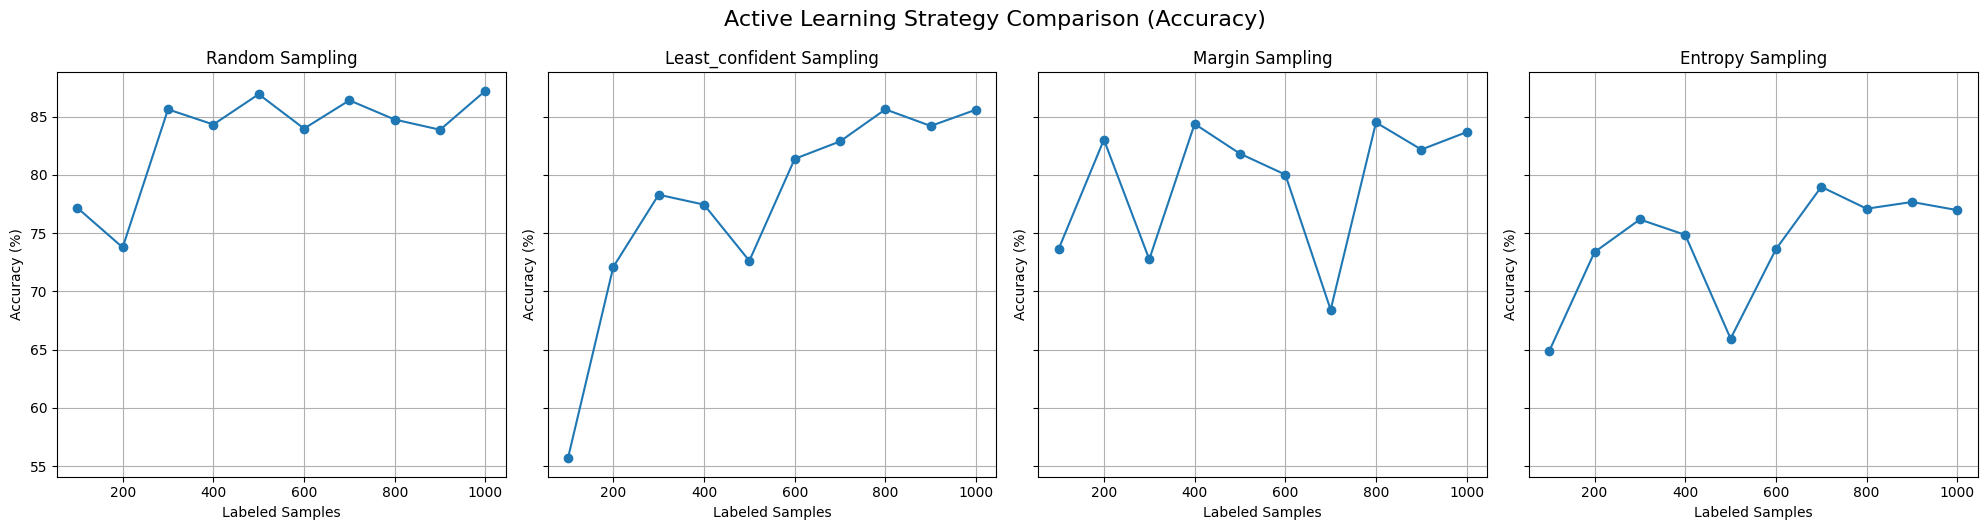

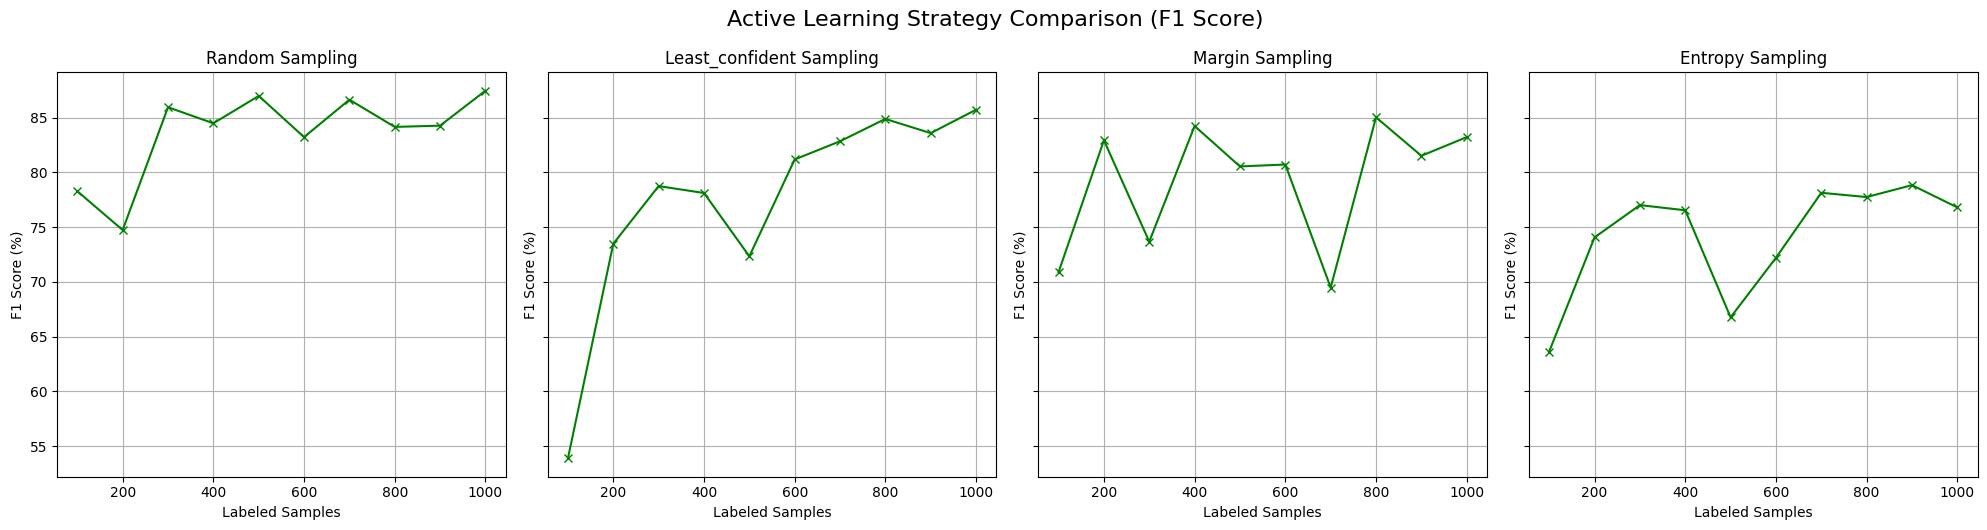

In [13]:
# Accuracy Plot
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i, (name, history) in enumerate(strategy_histories.items()):
    axs[i].plot(history["num_labeled"], [a * 100 for a in history["accuracy"]], marker="o")
    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("Accuracy (%)")
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (Accuracy)", fontsize=16, y=1.05)
plt.show()


# Average F1 Score Plot
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i, (name, history) in enumerate(strategy_histories.items()):
    axs[i].plot(history["num_labeled"], [a * 100 for a in history["avg_f1"]], marker="x", color='green')
    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("F1 Score (%)")  # FIXED THIS
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (F1 Score)", fontsize=16, y=1.05)
plt.show()

<hr>